In [21]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats
import networkx as nx
import os
import sys
import json
import random
import re
from math import ceil, floor, log, log2, log10, sqrt, exp, factorial, gcd, lcm, pi, e, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2, pow, atan, asin, acos, tan, sin, cos, sinh, cosh, tanh, asinh, acosh, atanh, degrees, radians, expm1, log1p, exp2, log2, fsum, gcd, lcm, tau, inf, nan, isinf, isnan, isfinite, copysign, fmod, frexp, ldexp, modf, trunc, erf, erfc, gamma, lgamma, hypot, atan2
from collections import Counter, defaultdict, OrderedDict, namedtuple, deque
from functools import partial, partialmethod, reduce, wraps, cache, lru_cache, cached_property, singledispatch, singledispatchmethod
from itertools import count, cycle, product as cartesian_product, permutations, combinations, combinations_with_replacement, accumulate, starmap
from tqdm import tqdm # from tqdm.notebook import tqdm
from uuid import uuid4
from datetime import datetime, timedelta
from time import time, sleep
from toolz import memoize, curry, diff, unique, valmap, valfilter, itemmap, itemfilter, keymap, keyfilter, merge_sorted, interleave, isdistinct, diff, peek, peekn, countby, juxt, excepts, merge, merge_with, assoc, dissoc
from more_itertools import unzip, chunked, chunked_even, minmax, filter_except, numeric_range, make_decorator,replace, locate,countable,unique_everseen, always_iterable,unique_justseen,map_except,count_cycle, mark_ends, sample, distribute, bucket, peekable, seekable,spy,transpose, sieve,polynomial_from_roots,flatten, intersperse, partition, powerset, collapse, split_at, flatten,split_before, split_after, split_when, take

sys.path.append(os.path.relpath("../../src/"))
from network_v3 import * # my classes and functions

In [22]:
SEED = 42

In [23]:
def uniform_sample(n ,long_grid = 100, lat_grid = 100, pop_size=200 , long_spread = 200, lat_spread = 200,seed = SEED):
    npr.seed(seed)
    x = npr.uniform([0,0,pop_size/(long_spread*lat_spread),pop_size/(long_spread*lat_spread)],[long_grid,lat_grid,long_spread,lat_spread],size=(n,4))
    y = npr.randint(0,pop_size ,size=(n,1)).transpose()
    # returns xy-coordinates, population, mean, spread, size
    return np.concatenate((x,y.transpose()),axis=1)

def normal_sample(n,mean = [0,0] , std = [1,1], seed = SEED):
    npr.seed(seed)
    covs = [[std[0],0],[0,std[1]]]
    x = npr.multivariate_normal(mean,covs,size=n)
    #plt.plot(x[:,0],x[:,1],'.')
    return x

In [24]:
# seed= SEED
# rng = npr.default_rng(seed = seed)
# population_centers = uniform_sample(10, long_grid = 80, lat_grid = 80, pop_size=250 , long_spread = 150, lat_spread = 150,seed = seed)
# population = [normal_sample(int(i[4]),(i[0],i[1]),(i[2],i[3]),seed=seed) for i in population_centers]
# population_midpoints = [(i[0],i[1]) for i in population_centers]
# population_midpoint = reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]),population_midpoints)
# population_midpoint = (population_midpoint[0]/len(population_midpoints),population_midpoint[1]/len(population_midpoints))
# population_spread = max([max([np.linalg.norm(i-population_midpoint) for i in j]) for j in population])
# population.append(normal_sample(1000,population_midpoint,(population_spread*2,population_spread*2),seed=seed))
# pop = np.concatenate(population,axis=0)

# plt.plot(pop[:,0],pop[:,1],marker='.',linestyle='None',color='g')

In [25]:
def city_sample(n ,long_grid = 80, lat_grid = 80, pop_size=250 , long_spread = 150, lat_spread = 150,seed = SEED,rd = 10):
    population_centers = uniform_sample(10, long_grid = 80, lat_grid = 80, pop_size=250 , long_spread = 150, lat_spread = 150,seed = seed)
    population = [normal_sample(int(i[4]),(i[0],i[1]),(i[2],i[3]),seed=seed) for i in population_centers]
    population_midpoints = [(i[0],i[1]) for i in population_centers]
    population_midpoint = reduce(lambda x,y: (x[0]+y[0],x[1]+y[1]),population_midpoints)
    population_midpoint = (population_midpoint[0]/len(population_midpoints),population_midpoint[1]/len(population_midpoints))
    population_spread = max([max([np.linalg.norm(i-population_midpoint) for i in j]) for j in population])
    population.append(normal_sample(1000,population_midpoint,(population_spread*2,population_spread*2),seed=seed))
    pop = np.concatenate(population,axis=0)
    pop_rd = np.array(list(map(lambda x: [round(x[0],rd),round(x[1],rd)],pop)))
    plt.plot(pop_rd[:,0], pop_rd[:,1],marker='.',linestyle='None',color='g')
    return pop_rd , population_centers, population_midpoint

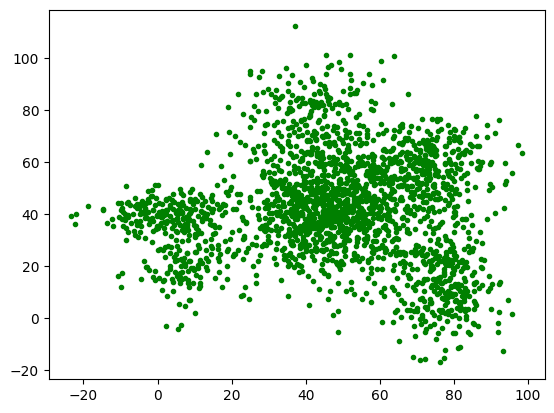

In [26]:
city_sample(10,rd=2,seed = 9);

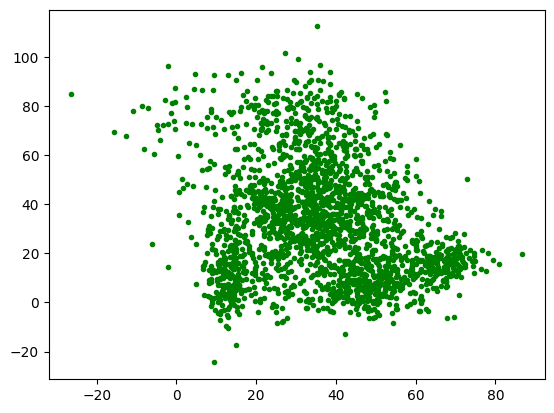

In [27]:
pop , population_centers, population_midpoint = city_sample(10,rd=2,seed = SEED)

population_midpoint_node = Node.make(*population_midpoint)
nodes = [Node.make(*i, weight = lambda x : x.dist_to(population_midpoint_node)) for i in pop]

In [28]:
def node_neighbors(node,nodes,radius, distance_function = lambda x,y : x.dist_to(y,metric = 'manhattan')):
    neighbors = []
    for i in nodes:
        if distance_function(node,i) < radius:
            neighbors.append(i)
    neighbors.remove(node)
    neighbors.sort(key = lambda x : distance_function(node,x))
    return neighbors

def neighborhood(node,nodes,min=3 ,distance_function = lambda x,y : x.dist_to(y,metric = 'manhattan')):
    r = 1
    x = node_neighbors(node,nodes,r,distance_function=distance_function)
    while len(x) < min:
        r+=1
        x = node_neighbors(node,nodes,r)
        if r > 100:
            break
    return x

neighbor_dict = {i:neighborhood(i,nodes,3) for i in nodes}

In [29]:
def road_picker(node, neighborhood):
    npr.seed(int(node.weight*1000))
    edges = [Edge.make(node,i,weight = lambda x: Node.dist(x.node1, x.node2,metric = 'manhattan')) for i in neighborhood]
    picks = min(max(npr.poisson(2),1),len(neighborhood)-1)
    res = [edges[0]] + list(npr.choice(edges[1:],size=picks))
    return res

In [30]:
def road_picker2(node, neighbor):
    edge = [Edge.make(node,i,weight = lambda x: Node.dist(x.node1, x.node2,metric = 'manhattan')) for i in neighbor]
    return edge

In [31]:
road_picker2(nodes[0],neighbor_dict[nodes[0]])

[Edge: Node: (35.17,74.75)||weight 38.98 -> Node: (34.92,75.37)||weight 39.35 || weight: 0.87,
 Edge: Node: (35.17,74.75)||weight 38.98 -> Node: (35.25,75.69)||weight 40.00 || weight: 1.02,
 Edge: Node: (35.17,74.75)||weight 38.98 -> Node: (35.70,74.14)||weight 38.90 || weight: 1.14,
 Edge: Node: (35.17,74.75)||weight 38.98 -> Node: (33.36,74.82)||weight 39.29 || weight: 1.88]

In [32]:
edges = []
for i in nodes:
    edges.extend(road_picker2(i,neighbor_dict[i]))
#edg = []
#[edg.append(edge) for edge in edges if edge not in edg];

In [33]:
city = Network(nodes,edges)

In [34]:
len(city.nodes), len(city.edges)

(2184, 6836)

In [35]:
nodes[0],nodes[1]

(Node: (35.17,74.75)||weight 38.98, Node: (36.75,90.49)||weight 56.30)

In [36]:
x = city.find_path(nodes[0],nodes[1])
x

[Node: (35.17,74.75)||weight 38.98,
 Node: (34.92,75.37)||weight 39.35,
 Node: (33.65,75.79)||weight 39.97,
 Node: (32.31,76.18)||weight 41.70,
 Node: (32.59,79.34)||weight 44.58,
 Node: (33.71,81.37)||weight 45.49,
 Node: (34.61,83.40)||weight 47.07,
 Node: (35.95,86.82)||weight 51.83,
 Node: (36.75,90.49)||weight 56.30]

In [37]:
city.fill_path_edges(x)

TypeError: unsupported operand type(s) for -: 'Node' and 'int'